In [2]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation
from IPython.display import display, clear_output


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
class custom_model:

    def __init__(self):
        
        ### Hamiltonian parameters
        self.m = 1.
        self.l = 1.
        
        self.Δt = 0.05
        self.N = 40
        
        ### Neural Networks
        xavier=tf.keras.initializers.GlorotUniform()
        
        self.V1=tf.keras.layers.Dense(1,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.V2=tf.keras.layers.Dense(32,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.V3=tf.keras.layers.Dense(32,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.Vout=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        
        self.K1=tf.keras.layers.Dense(1,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.K2=tf.keras.layers.Dense(32,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.K3=tf.keras.layers.Dense(32,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.Kout=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        
        
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.01)

    def runV(self, X):
        #with tf.device('/cpu:0'):
        boom = self.V1(X)
        boom1 = self.V2(boom)
        boom2 = self.V3(boom1)
        boom3 = self.Vout(boom2)
        return boom3
    
    def runK(self, X):
        #with tf.device('/cpu:0'):
        boom = self.K1(X)
        boom1 = self.K2(boom)
        boom2 = self.K3(boom1)
        boom3 = self.Kout(boom2)
        return boom3

    ####################################### Leapfrog for NN #######################
    
    def leapfrog_nn(self, q0, p0, Δt, N):
        q = [tf.constant([[q0]])]
        p = [tf.constant([[p0]])]
        p̄ = []
        for i in range(N):
            p̄.append(p[-1] + 0.5*Δt*self.runV(q[-1]))
            q.append(q[-1] + Δt*self.runK(p̄[-1]))
            p.append(p̄[-1] + 0.5*Δt*self.runV(q[-1]))
        return [q, p]
    
    ############################### Generate training dataset from leapfrog ######
    
    ### H = F(p) + T(q) separable Hamiltonian
    def V(self, p):
        return p/(self.m*self.l*self.l)
    
    def K(self, q):
        return -self.m*self.l*tf.math.sin(q)
    
    ### Leapfrog integrator with V and K
    def leapfrog(self, q0, p0, Δt, N):
        q = [tf.constant([[q0]])]
        p = [tf.constant([[p0]])]
        p̄ = []
        for i in range(N):
            p̄.append(p[-1] + 0.5*Δt*self.V(q[-1]))
            q.append(q[-1] + Δt*self.K(p̄[-1]))
            p.append(p̄[-1] + 0.5*Δt*self.V(q[-1]))
        return [q, p]
    
    
    ##################################### Loss function ##########################
    
    def get_loss(self, q0, p0):
        prediction = tf.convert_to_tensor(self.leapfrog_nn(q0, p0, self.Δt, self.N))
        true_trajectory = tf.convert_to_tensor(self.leapfrog(q0, p0, self.Δt, self.N))
        MSE = tf.reduce_sum((prediction - true_trajectory)**2)
        return MSE

    #get gradient
    def get_gradV(self, q0, p0):
        with tf.GradientTape() as tape:
            tape.watch(self.V1.variables)
            tape.watch(self.V2.variables)
            tape.watch(self.V3.variables)
            tape.watch(self.Vout.variables)
            L = self.get_loss(q0, p0)
            g = tape.gradient(L, [self.V1.variables[0],self.V1.variables[1],self.V2.variables[0],self.V2.variables[1],self.V3.variables[0],self.V3.variables[1],self.Vout.variables[0],self.Vout.variables[1]])
        return g
    
    def get_gradK(self, q0, p0):
        with tf.GradientTape() as tape:
            tape.watch(self.K1.variables)
            tape.watch(self.K2.variables)
            tape.watch(self.K3.variables)
            tape.watch(self.Kout.variables)
            L = self.get_loss(q0, p0)
            g = tape.gradient(L, [self.K1.variables[0],self.K1.variables[1],self.K2.variables[0],self.K2.variables[1],self.K3.variables[0],self.K3.variables[1],self.Kout.variables[0],self.Kout.variables[1]])
        return g
    
    # perform gradient descent
    def network_learnV(self, q0, p0):
        
        g = self.get_gradV(q0, p0)
        self.train_op.apply_gradients(zip(g, [self.V1.variables[0],self.V1.variables[1],self.V2.variables[0],self.V2.variables[1],self.V3.variables[0],self.V3.variables[1],self.Vout.variables[0],self.Vout.variables[1]]))


    def network_learnK(self, q0, p0):
        
        g = self.get_gradK(q0, p0)
        self.train_op.apply_gradients(zip(g, [self.K1.variables[0],self.K1.variables[1],self.K2.variables[0],self.K2.variables[1],self.K3.variables[0],self.K3.variables[1],self.Kout.variables[0],self.Kout.variables[1]]))



### Untrained Model

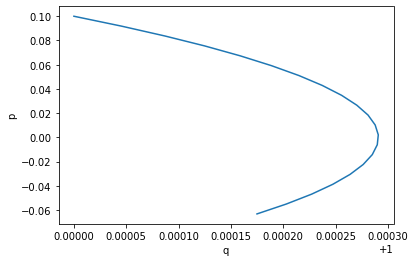

In [4]:
Model = custom_model()

PQ = Model.leapfrog_nn(1., 0.1, 0.05, 20)
q = []
p = []
for i in range(len(PQ[0])):
    q.append(PQ[0][i].numpy()[0][0])
    p.append(PQ[1][i].numpy()[0][0])

plt.plot(q, p)
plt.xlabel("q")
plt.ylabel("p")
plt.show()

### Symplectic leapfrog integrator of the form:

## $$ \begin{equation}
    \begin{aligned}
    \textbf{p}_{n+1/2} &= \textbf{p}_{n} - \frac{1}{2} \Delta t V(\textbf{q}_{n})\\
    \textbf{q}_{n+1} &= \textbf{q}_{n} + \Delta t K(\textbf{p}_{n + 1/2})\\
    \textbf{p}_{n+1} &= \textbf{p}_{n+1/2} - \frac{1}{2} \Delta t V(\textbf{q}_{n+1})\\
    \end{aligned}
    \end{equation}
$$

In [5]:
def leapfrog(V, K, q0, p0, Δt, N):
    q = [q0]
    p = [p0]
    p̄ = []
    for i in range(N):
        p̄.append(p[-1] + 0.5*Δt*V(q[-1]))
        q.append(q[-1] + Δt*K(p̄[-1]))
        p.append(p̄[-1] + 0.5*Δt*V(q[-1]))
    return [q, p]

def plot_true_tr(q0, p0, Δt, N):
    PQ = Model.leapfrog(q0_test, p0_test, dt_test, N_test)
    q = []
    p = []
    for i in range(len(PQ[0])):
        q.append(PQ[0][i].numpy()[0][0])
        p.append(PQ[1][i].numpy()[0][0])
    plt.plot(p, q)
    

### Example

In [6]:
#Hamilton equations
m = 1.
l = 1.
def V(q):
    return -m*l*mt.sin(q)
def K(p):
    return p/(m*l*l)

#leapfrog integrator parameters
N_p = 20
Δt = 0.05

#other parameters
N_tr = 50
TDataset = []
u0s = []

start_time = time.time()

for i in range(N_tr):
    u0 = [rdm.choice([-1,1])*rdm.random()*3, rdm.choice([-1,1])*rdm.random()*3]
    u0s.append(u0)
    TDataset.append(leapfrog(V, K, u0[0], u0[1], Δt, N_p))

print("running time for " + str(N_tr) + " trajectories of " + str(N_p) + " points each: %s seconds" % (time.time() - start_time))

running time for 50 trajectories of 20 points each: 0.0019943714141845703 seconds


### Training Dataset

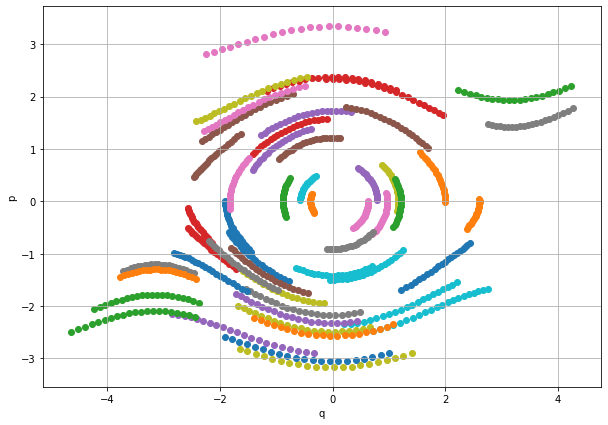

In [7]:
plt.figure(figsize=(10,7))
for i in range(N_tr):
    plt.scatter(TDataset[i][0], TDataset[i][1])

plt.xlabel("q")
plt.ylabel("p")
plt.grid("true")
plt.show()

### Training the model with random initial conditions $(q_{0},p_{0}) \in [-\pi, \pi] \times [-\pi, \pi]$

In [12]:
epochs = 100
each = 5
losses = []

start_time = time.time()

for i in range(epochs):
    u0 = [rdm.choice([-1,1])*rdm.random()*3, rdm.choice([-1,1])*rdm.random()*3]
    print((i/epochs)*100, "%")
    loss = Model.get_loss(u0[0], u0[1])
    losses.append(loss)
    print("loss = ", loss)
    
    for j in range(each):
        Model.network_learnV(u0[0], u0[1])
        Model.network_learnK(u0[0], u0[1])

print("Running time: %s seconds ---" % (time.time() - start_time))

0.0 %
loss =  tf.Tensor(91.61407, shape=(), dtype=float32)
1.0 %
loss =  tf.Tensor(15.788473, shape=(), dtype=float32)
2.0 %
loss =  tf.Tensor(34.45543, shape=(), dtype=float32)
3.0 %
loss =  tf.Tensor(2.494716, shape=(), dtype=float32)
4.0 %
loss =  tf.Tensor(13.773033, shape=(), dtype=float32)
5.0 %
loss =  tf.Tensor(137.40863, shape=(), dtype=float32)
6.0 %
loss =  tf.Tensor(46.92041, shape=(), dtype=float32)
7.000000000000001 %
loss =  tf.Tensor(20.496408, shape=(), dtype=float32)
8.0 %
loss =  tf.Tensor(48.927834, shape=(), dtype=float32)
9.0 %
loss =  tf.Tensor(51.02881, shape=(), dtype=float32)
10.0 %
loss =  tf.Tensor(23.762215, shape=(), dtype=float32)
11.0 %
loss =  tf.Tensor(44.26272, shape=(), dtype=float32)
12.0 %
loss =  tf.Tensor(20.068903, shape=(), dtype=float32)
13.0 %
loss =  tf.Tensor(115.53909, shape=(), dtype=float32)
14.000000000000002 %
loss =  tf.Tensor(7.622698, shape=(), dtype=float32)
15.0 %
loss =  tf.Tensor(10.089249, shape=(), dtype=float32)
16.0 %
loss =

### Trained model

In [ ]:
for i in range(10):
    PQ = Model.leapfrog_nn(rdm.choice([-1,1])*rdm.random()*2, rdm.choice([-1,1])*rdm.random()*2, 0.05, 200)
    p = []
    q = []
    for i in range(len(PQ[0])):
        q.append(PQ[0][i].numpy()[0][0])
        p.append(PQ[1][i].numpy()[0][0])

    plt.plot(q, p)

plt.xlabel("q")
plt.ylabel("p")
plt.show()

### Training the model along one single trajectory

In [496]:
#Model = custom_model()
losses = []
epochs = 800
q0 = 1.
p0 = 0.6

start_time = time.time()

for i in range(epochs):
    if i%1 == 0:
        clear_output(wait=True)
        display(str((i/epochs)*100) + "%")  
    losses.append(Model.get_loss(q0, p0).numpy())
    Model.network_learnV(q0, p0)
    Model.network_learnK(q0, p0)

print("Training time: %s seconds" % (time.time() - start_time))

'99.875%'

Training time: 395.9649488925934 seconds


### Plot the loss

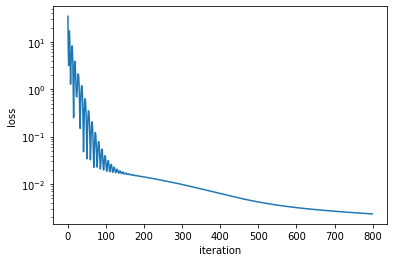

In [493]:
plt.plot(losses)
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.show()

### Trained model: plot the result

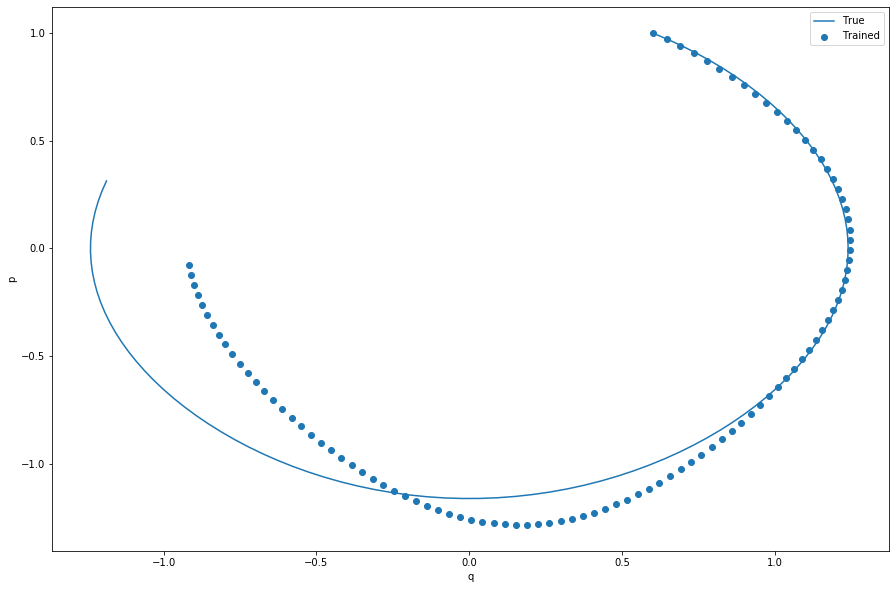

In [495]:
plt.figure(figsize=(15,10))

q0_test, p0_test, dt_test, N_test = [q0, p0, 0.05, 100]

PQ_nn = Model.leapfrog_nn(q0_test, p0_test, dt_test, N_test)
q_nn = []
p_nn = []
for i in range(len(PQ_nn[0])):
    q_nn.append(PQ_nn[0][i].numpy()[0][0])
    p_nn.append(PQ_nn[1][i].numpy()[0][0])
plt.scatter(p_nn, q_nn)

PQ = Model.leapfrog(q0_test, p0_test, dt_test, N_test)
q = []
p = []
for i in range(len(PQ[0])):
    q.append(PQ[0][i].numpy()[0][0])
    p.append(PQ[1][i].numpy()[0][0])
plt.plot(p, q)

plt.legend(('True', 'Trained'), loc='upper right')
plt.xlabel("q")
plt.ylabel("p")
plt.show()